In [8]:
from pathlib import Path
from ultralytics import YOLO

models_dir = Path("./models")
models_dir.mkdir(exist_ok=True)

DET_MODEL_NAME = "yolov8n"

det_model = YOLO(models_dir / f"{DET_MODEL_NAME}.pt")
label_map = det_model.model.names

# Need to make en empty call to initialize the model
res = det_model()
det_model_path = models_dir / f"{DET_MODEL_NAME}_openvino_model/{DET_MODEL_NAME}.xml"
if not det_model_path.exists():
    det_model.export(format="openvino", dynamic=True, half=True)



WARNING ⚠️ 'source' is missing. Using 'source=/home/uli/.local/lib/python3.10/site-packages/ultralytics/assets'.

image 1/2 /home/uli/.local/lib/python3.10/site-packages/ultralytics/assets/bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 112.1ms
image 2/2 /home/uli/.local/lib/python3.10/site-packages/ultralytics/assets/zidane.jpg: 384x640 2 persons, 1 tie, 87.5ms
Speed: 2.2ms preprocess, 99.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


In [9]:
from ultralytics import YOLO
from ultralytics.solutions import ObjectCounter
import cv2
import time
import collections
import numpy as np
from IPython import display
import torch
import openvino as ov


def run_inference(source, device):
    core = ov.Core()

    det_ov_model = core.read_model(det_model_path)
    ov_config = {}

    if device.value != "CPU":
        det_ov_model.reshape({0: [1, 3, 640, 640]})
    if "GPU" in device.value or ("AUTO" in device.value and "GPU" in core.available_devices):
        ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}
    compiled_model = core.compile_model(det_ov_model, device.value, ov_config)

    def infer(*args):
        result = compiled_model(args)
        return torch.from_numpy(result[0])

    # Use openVINO as inference engine
    det_model.predictor.inference = infer
    det_model.predictor.model.pt = False
    try:
        cap = cv2.VideoCapture(source)
        assert cap.isOpened(), "Error reading video file"

        line_points = [(0, 300), (1080, 300)]  # line or region points
        classes_to_count = [0]  # person is class 0 in the COCO dataset

        # Init Object Counter
        counter = ObjectCounter(
            view_img=False, reg_pts=line_points, classes_names=det_model.names, draw_tracks=True, line_thickness=2, view_in_counts=False, view_out_counts=False
        )
        # Processing time
        processing_times = collections.deque(maxlen=200)

        while cap.isOpened():
            success, frame = cap.read()
            if not success:
                print("Video frame is empty or video processing has been successfully completed.")
                break

            start_time = time.time()
            tracks = det_model.track(frame, persist=True, show=False, classes=classes_to_count, verbose=False)
            frame = counter.start_counting(frame, tracks)
            stop_time = time.time()

            processing_times.append(stop_time - start_time)

            # Mean processing time [ms].
            _, f_width = frame.shape[:2]
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=2,
                lineType=cv2.LINE_AA,
            )

            # Get the counts. Counts are getting as 'OUT'
            # Modify this logic accordingly
            counts = counter.out_counts

            # Define the text to display
            text = f"Count: {counts}"
            fontFace = cv2.FONT_HERSHEY_COMPLEX
            fontScale = 0.75  # Adjust scale as needed
            thickness = 2

            # Calculate the size of the text box
            (text_width, text_height), _ = cv2.getTextSize(text, fontFace, fontScale, thickness)
# Define the upper right corner for the text
            top_right_corner = (frame.shape[1] - text_width - 20, 40)
            # Draw the count of "OUT" on the frame
            cv2.putText(
                img=frame,
                text=text,
                org=(top_right_corner[0], top_right_corner[1]),
                fontFace=fontFace,
                fontScale=fontScale,
                color=(0, 0, 255),
                thickness=thickness,
                lineType=cv2.LINE_AA,
            )

            # Show the frame
            _, encoded_img = cv2.imencode(ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100])
            # Create an IPython image.
            i = display.Image(data=encoded_img)
            # Display the image in this notebook.
            display.clear_output(wait=True)
            display.display(i)
    except KeyboardInterrupt:
        print("Interrupted")

    cap.release()
    cv2.destroyAllWindows()


In [10]:
WEBCAM_INFERENCE = False

if WEBCAM_INFERENCE:
    VIDEO_SOURCE = 0  # Webcam
else:
   VIDEO_SOURCE = "https://github.com/intel-iot-devkit/sample-videos/raw/master/people-detection.mp4"


In [11]:
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)
open("notebook_utils.py", "w").write(r.text)

from notebook_utils import device_widget

device = device_widget()

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

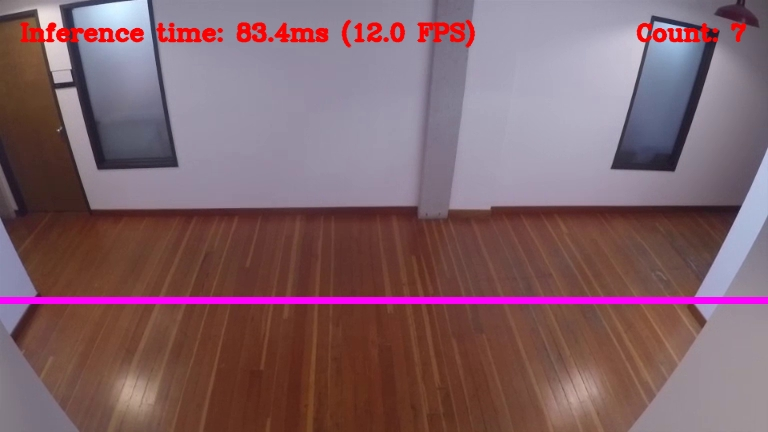

Video frame is empty or video processing has been successfully completed.


In [12]:
run_inference(
    source=VIDEO_SOURCE,
    device=device,
)